# Definition of Necessary Functions and Classes:
A. Function to Generate Negative Labels: Generate negative samples for training.

B. Function to Overlay Label onto the Input Data: Overlay the correct class onto the input data for positive forward pass.

C. Custom Net Class: Definition of the network using the custom forward-forward approach.

D. Custom Layer Class: Definition of a custom layer class to be used in the network.

E. Network Hyperparameters and Device Setup: Set the hyperparameters for the network and configure the computation device.

# Implementation Steps:
1. Load Data: Load the MNIST dataset for training and testing.

2. Create Network: Instantiate the network architecture.

3. Train the Network: Train the network using the forward-forward algorithm.

4. Test the Network: Test the network's performance on the MNIST test set.

# Import Libraries

In [15]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch 
import torch.nn as nn  
import torchvision
from torchvision.datasets import MNIST 
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda 
from torch.utils.data import DataLoader 
from torch.optim import Adam 

# A. Function to generate negative labels

In [16]:
# Generates negative labels for the training data, which are required for contrastive divergence training

def get_y_neg(y):

    # clone the original labels
    y_neg = y.clone()

    # loop through each sample in the labels
    for idx, y_samp in enumerate(y):
        
        # create a list of all possible class labels
        allowed_indices = list(range(10))

        # remove the correct label from the list, leaving only incorrect labels
        allowed_indices.remove(y_samp.item())

        # assigning a random label from allowed_indices to y_neg[idx].
        y_neg[idx] = torch.tensor(allowed_indices)[torch.randint(len(allowed_indices), size=(1,))].item()

    # return the labels with incorrect class, moved to the specified device (CPU or GPU)
    return y_neg.to(device)

# B. Function to overlay label onto the input data

In [17]:
# Overlays label info onto the input data, making a certain position in the tensor representative of the label

def overlay_y_on_x(x, y, classes=10):
    
    # Create a copy of the input tensor x
    x_ = x.clone()

    # for all samples, set the first 10 column values to 0
    x_[:, :classes] *= 0.0

    # For each sample, set the feature at index corresponding to the class y to be the max value in x
    x_[range(x.shape[0]), y] = x.max()

    # Return the transformed tensor
    return x_

# C. Custom Net Class

In [19]:
# Define a Net class that inherits from torch.nn.Module which is the base class for all neural network modules in PyTorch.
class Net(torch.nn.Module):

    # Initialize the Net class with dimensions of the neural network layers
    def __init__(self, dims):

        # Initialize the parent class torch.nn.Module, Net is the subclass and torch.nn.Module is the parent class
        super().__init__()

        # Initialize an empty layers list that will store the layers of the neural network
        self.layers = []

        # Create the layers of the neural network
        for d in range(len(dims) - 1):
            
            # Append a new layer to the layers list and move it to the appropriate device
            self.layers = self.layers + [Layer(dims[d], dims[d + 1]).to(device)]

    # Define a function to make predictions using the neural network
    def predict(self, x):

        # This list will store a measure of how much the input tensor x looks like each possible digit (from 0 to 9).
        goodness_per_label = []

        # For each possible label (0 to 9)
        for label in range(10):

            # Apply the label overlay to the input to make h tensor (50000, 784) of same size as x 
            h = overlay_y_on_x(x, label)

            

            # Create a list to store the goodness of each layer for this label
            goodness = []

            # Pass the input through each Layer class element in layers list. 
            for layer in self.layers:
                
                # Apply the current layer to the transformed input tensor h, and then stores the result back into h.
                h = layer(h)

                # after layer 1, h size: (10000, 500)
                # after layer 2, h size: (10000, 500)

                # Add the squared mean (mean along each rows) of the output of this layer to the goodness list
                goodness = goodness + [h.pow(2).mean(1)]

                

            # Add the sum of the goodness of all layers for this label to the goodness_per_label list
            goodness_per_label += [sum(goodness).unsqueeze(1)]

            
            

        # Concatenate all the goodness_per_label tensors along dimension 1
        goodness_per_label = torch.cat(goodness_per_label, 1)

        

        # Return the label with the highest goodness
        return goodness_per_label.argmax(1)
    
        

    # Define a function to train the neural network
    def train(self, x_pos, x_neg):

        # Initialize the positive and negative inputs
        h_pos, h_neg = x_pos, x_neg

        # For each layer in the neural network
        for i, layer in enumerate(self.layers):

            # Print which layer is currently being trained
            print("training layer: ", i)

            # Train the layer using the positive and negative inputs
            # layer.train() returns the positive and negative outputs of the layer which are 2d tensors of shape (50000, 500) for layer 1 and (50000, 500) for layer 2
            h_pos, h_neg = layer.train(h_pos, h_neg)

# D. Custom Layer Class

In [20]:
# Net is the main network and contains several instances of Layer, which represents individual layers of the network.
class Layer(nn.Linear):

    def __init__(self, in_features, out_features, bias=True, device=None, dtype=None):

        # Initialize the parent class, torch.nn.Linear
        super().__init__(in_features, out_features, bias, device, dtype)

        # Define a ReLU (Rectified Linear Unit) activation function
        self.relu = torch.nn.ReLU()

        # Define an Adam optimizer for this layer, with the learning rate defined by args.lr
        self.opt = Adam(self.parameters(), lr=args.lr)

        '''
        learning rate = 0.3
        '''

        # Define a threshold for the loss function, specified by args.threshold
        self.threshold = args.threshold

        '''
        3
        '''

        # Define the number of training epochs for this layer, specified by args.epochs
        self.num_epochs = args.epochs

        '''
        1000
        '''

    # Make each sample as unit magnitude then do A = X*W.T + B
    def forward(self, x):

        # Normalize the input tensor along each row
        # Each row in x_direction is a unit vector in the direction of the corresponding row in x
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)

        
        # Compute the linear transformation followed by a ReLU activation
        # weight.T is 2D tensor of shape (784, 500)
        return self.relu(torch.mm(x_direction, self.weight.T) + self.bias.unsqueeze(0))


    # train a layer
    def train(self, x_pos, x_neg):
        
        # initialize lists to hold values
        loss_values = []
        g_pos_values = []
        g_neg_values = []

        # initialize figure
        fig = plt.figure(figsize=(12,8))

        # For each layer epoch 
        for i in range(self.num_epochs):

            # Compute the goodness for the positive and negative samples
            g_pos = self.forward(x_pos).pow(2).mean(1)

            g_neg = self.forward(x_neg).pow(2).mean(1)


            
            # Compute the loss using the computed goodness and the specified threshold
            loss = torch.log(1 + torch.exp(torch.cat([-g_pos + self.threshold, g_neg - self.threshold]))).mean()

            # Zero the gradients
            self.opt.zero_grad()


            # Compute the backward pass
            loss.backward()


            # Perform a step of optimization
            self.opt.step()


            if i % args.log_interval == 0:
                loss_values.append(loss.item())
                g_pos_values.append(g_pos.mean().item())  # take mean of all batch values
                g_neg_values.append(g_neg.mean().item())  # take mean of all batch values

                # plotting
                plt.subplot(3,1,1)
                plt.plot(loss_values, color='blue')
                plt.title("Loss during training")

                plt.subplot(3,1,2)
                plt.plot(g_pos_values, color='green')
                plt.title("g_pos during training")

                plt.subplot(3,1,3)
                plt.plot(g_neg_values, color='red')
                plt.title("g_neg during training")

                plt.tight_layout()
                clear_output(wait=True)  # this clears the output of the cell, useful for updating the plots
                plt.show()

            # Print the loss at each step
            print(f'Loss at step {i}: {loss.item()}')

        # compute the output of the layer (A) for both positive and negative samples
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

# E. Network Hyperparameters and device setup

In [26]:
class Args:
    train_size = 5000
    test_size = 1000
    epochs = 50
    lr = 0.05
    no_cuda = True
    no_mps = True
    save_model = False 
    threshold = 0
    seed = 1234
    log_interval = 10
    
args = Args()


device = torch.device("cpu")

train_kwargs = {"batch_size": args.train_size} # dictionary specifying train batch size
test_kwargs = {"batch_size": args.test_size} # dictionary specifying test batch size



# 1. Load data

In [27]:
# 1) Converted to a tensor. MNIST are PIL images, so convert them to tensors to use with PyTorch
# 2) Normalized for the MNIST dataset
# 3) Flattened to a 1D tensor of 784 elements (28x28 pixels)
transform = Compose( 
    [
        ToTensor(),                                                                   
        Normalize((0.1307,), (0.3081,)),       
        Lambda(lambda x: torch.flatten(x)),    
    ]
)

# Create train and test DataLoader instances using the MNIST dataset
train_loader = DataLoader(MNIST("./data/", train=True, download=True, transform=transform), **train_kwargs) 
test_loader = DataLoader(MNIST("./data/", train=False, download=True, transform=transform), **test_kwargs) 

# 2. Create network

In [28]:
# Create an instance of Net class with an input dim of 784 neurons to match the flattened 28x28 pixel MNIST images
# and two intermediate dims of 500 each. 3 dims so we will have a 2 layer network.
net =  Net([784, 100, 100, 100, 100])

# 3. Train the network

In [29]:
# x is a 2D tensor of size (batch_size, 784) and y is a 1D tensor of size (batch_size,).
x, y = next(iter(train_loader))

# Move the input data and labels to the specified device (CPU or GPU).
x, y = x.to(device), y.to(device)

# overlay_y_on_x() function returns a 2D tensor of size (batch_size, 784)
x_pos = overlay_y_on_x(x, y)

# get_y_neg() function returns a 1D tensor of size (batch_size,) with the negative labels.
y_neg = get_y_neg(y)

# overlay_y_on_x() function returns a 2D tensor of size (batch_size, 784)
x_neg = overlay_y_on_x(x, y_neg)

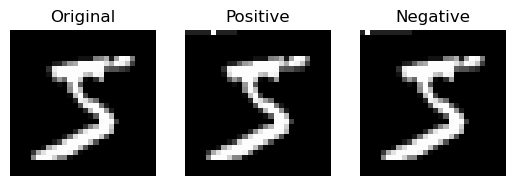

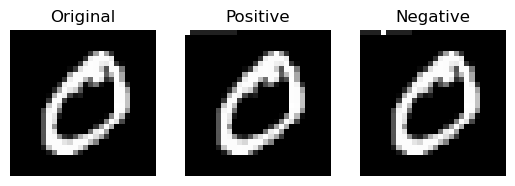

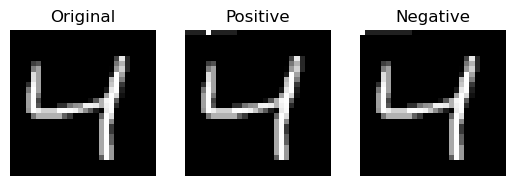

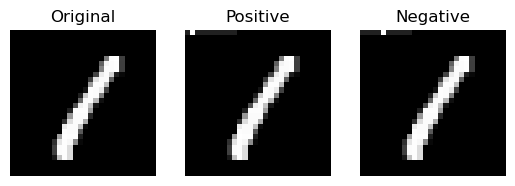

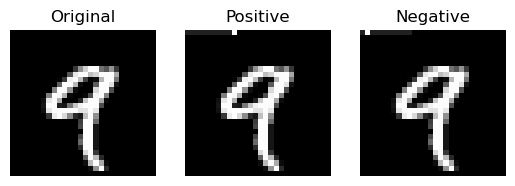

In [30]:
# Convert the tensors back to numpy arrays for plotting
x_np = x.cpu().numpy()
x_pos_np = x_pos.cpu().numpy()
x_neg_np = x_neg.cpu().numpy()

# Reshape the images from 784 to 28x28 if necessary
x_np = x_np.reshape(-1, 28, 28)
x_pos_np = x_pos_np.reshape(-1, 28, 28)
x_neg_np = x_neg_np.reshape(-1, 28, 28)

# Plot 5 samples
for i in range(5):
    fig, axs = plt.subplots(1, 3)
    
    # Original images
    axs[0].imshow(x_np[i], cmap='gray')
    axs[0].set_title('Original')
    axs[0].axis('off')

    # Positive images
    axs[1].imshow(x_pos_np[i], cmap='gray')
    axs[1].set_title('Positive')
    axs[1].axis('off')

    # Negative images
    axs[2].imshow(x_neg_np[i], cmap='gray')
    axs[2].set_title('Negative')
    axs[2].axis('off')

    plt.show()

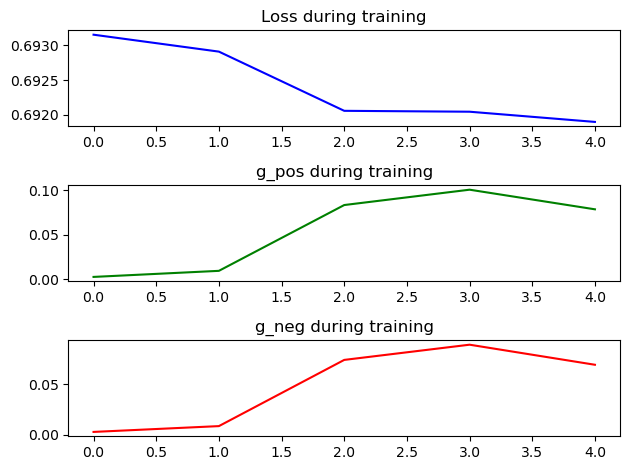

Loss at step 40: 0.6918973922729492
Loss at step 41: 0.6918821334838867
Loss at step 42: 0.691881000995636
Loss at step 43: 0.6918836236000061
Loss at step 44: 0.6918764114379883
Loss at step 45: 0.6918575167655945
Loss at step 46: 0.691837728023529
Loss at step 47: 0.6918261051177979
Loss at step 48: 0.691821277141571
Loss at step 49: 0.6918166875839233


In [31]:
# Train the network with the positive and negative examples.
net.train(x_pos, x_neg)

In [32]:
# Predict the labels for the training data, compare them to the actual labels, and calculate the error rate.
#print("train error:", 1.0 - net.predict(x).eq(y).float().mean().item())
print("Train Accuracy: {:.2f}%".format(100 * net.predict(x).eq(y).float().mean().item()))

Train Accuracy: 82.32%


# 4. Test the Network

In [33]:
# Fetch one batch of the test data.
x_te, y_te = next(iter(test_loader))

# Move the test data and labels to the specified device (CPU or GPU).
x_te, y_te = x_te.to(device), y_te.to(device)


# Predict the labels for the test data, compare them to the actual labels, and calculate the error rate.
#print("test error:", 1.0 - net.predict(x_te).eq(y_te).float().mean().item())
print("Test Accuracy: {:.2f}%".format(100 * net.predict(x_te).eq(y_te).float().mean().item()))

Test Accuracy: 76.00%
